Imports

In [5]:
%load_ext autoreload
%autoreload 2
%autosave 60

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt

# change to LaTeX style fonts
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
plt.rcParams.update({"font.size": 16})

from fisher_information import *
from QFIM_SMSV import QFIM_SMSV

# constants
# Bang Wong color blind--friendly colours
COLOURS = {
    "Black": "#000000",
    "Orange": "#E69F00",
    "Sky blue": "#56B4E9",
    "Bluish green": "#009E73",
    "Yellow": "#F0E442",
    "Blue": "#0072B2",
    "Vermillion": "#D55E00",
    "Reddish purple": "#CC79A7",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 60 seconds


Basic example

In [20]:
settings = dict(
    sigma=0.001,
    delta_sigma=1e-10,
    encoding=lambda sigma: encode_Fock_state(3, sigma),
    loss_channel=lambda rho: loss_binomial(rho, 0.1),
)

FIs(**settings)

(5.248830270554842, 5.248845741004432)

Plot versus n

In [294]:
n_list = np.arange(0, 10)
eta_meas = 0.1

settings = dict(
    sigma=0.001,
    delta_sigma=1e-10,
)

chosen_dependencies = lambda n, eta: dict(
    encoding=lambda sigma: encode_Fock_state(n, sigma),
    loss_channel=lambda rho: loss_binomial(rho, eta),
)

# n, FIlossless, QFIlossless, FIlossy, QFIlossy
fi_list = np.empty((len(n_list), 5))
fi_list[:, 0] = n_list
for n in n_list:
    fi_list[n, 1:3] = FIs(**chosen_dependencies(n, 0), **settings)
    fi_list[n, 3:] = FIs(**chosen_dependencies(n, eta_meas), **settings)

/home/james/Code/PhD/source/pleasantPheasant/numerical_environment.py:178: RuntimeWarning: invalid value encountered in true_divide
  eta_input (float): input loss power fraction
/home/james/Code/PhD/source/pleasantPheasant/./from_Simon/python_translation/QFImixed_finite.py:43: RuntimeWarning: invalid value encountered in double_scalars
  4


Compare to Mathematica results

In [295]:
# lossless results
file = "./data/Fock_versus_n_lossless.txt"
df_lossless = pd.read_csv(file, header=None, names=["n", "CFI"])

# lossy results
file = "./data/Fock_versus_n.txt"
df_lossy = pd.read_csv(file, header=None, names=["n", "CFI"])

# CFI residuals
residuals_lossless = fi_list[:, 1] - df_lossless[df_lossless["n"] <= max(n_list)]["CFI"]
residuals_lossy = fi_list[:, 3] - df_lossy[df_lossy["n"] <= max(n_list)]["CFI"]

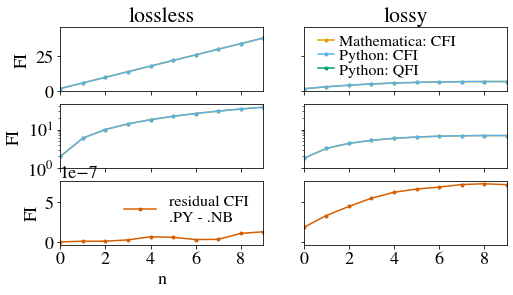

In [297]:
ymax = 1.2 * np.max(fi_list[:, 1:3][~np.isnan(fi_list[:, 1:3])])
c0, c1, c2 = list(COLOURS.values())[1:4]

plt.rcParams.update({"font.size": 18})
fig, axs = plt.subplots(3, 2, sharex=True, sharey="row", figsize=(8, 4))

axs[0, 0].plot(
    df_lossless["n"], df_lossless["CFI"], marker=".", label="Mathematica: CFI", color=c0
)
axs[0, 0].plot(fi_list[:, 0], fi_list[:, 1], marker=".", label="Python: CFI", color=c1)
axs[0, 0].plot(fi_list[:, 0], fi_list[:, 2], marker=".", label="Python: QFI", color=c2)
axs[0, 0].set(ylabel="FI", ylim=(0, ymax), title="lossless")

axs[1, 0].semilogy(
    df_lossless["n"], df_lossless["CFI"], marker=".", label="Mathematica: CFI", color=c0
)
axs[1, 0].semilogy(
    fi_list[:, 0], fi_list[:, 1], marker=".", label="Python: CFI", color=c1
)
axs[1, 0].semilogy(
    fi_list[:, 0], fi_list[:, 2], marker=".", label="Python: QFI", color=c2
)
axs[1, 0].set(ylabel="FI", ylim=(1, ymax))
axs[1, 0].set_xticks(n_list[::2])

axs[2, 0].plot(
    fi_list[:, 0],
    residuals_lossless,
    marker=".",
    label="residual CFI\n.PY - .NB",
    color=COLOURS["Vermillion"],
)
axs[2, 0].set(xlabel="n", ylabel="FI", xlim=(0, max(n_list)))
axs[2, 0].set_xticks(n_list[::2])
axs[2, 0].legend(
    frameon=False,
    fontsize=16,
)

# lossy plots
axs[0, 1].plot(
    df_lossy["n"], df_lossy["CFI"], marker=".", label="Mathematica: CFI", color=c0
)
axs[0, 1].plot(fi_list[:, 0], fi_list[:, 3], marker=".", label="Python: CFI", color=c1)
axs[0, 1].plot(fi_list[:, 0], fi_list[:, 4], marker=".", label="Python: QFI", color=c2)
axs[0, 1].legend(
    handlelength=1,
    labelspacing=0,
    frameon=False,
    handletextpad=0.3,
    fontsize=16,
)
axs[0, 1].set(title="lossy")

axs[1, 1].semilogy(
    df_lossy["n"], df_lossy["CFI"], marker=".", label="Mathematica: CFI", color=c0
)
axs[1, 1].semilogy(fi_list[:, 0], fi_list[:, 3], marker=".", label="CFI", color=c1)
axs[1, 1].semilogy(fi_list[:, 0], fi_list[:, 4], marker=".", label="QFI", color=c2)

axs[2, 1].plot(
    fi_list[:, 0],
    residuals_lossy,
    marker=".",
    label="residual CFI",
    color=COLOURS["Vermillion"],
)

fig.savefig("./figures/Fock_FI_python_vs_mathematica.pdf", bbox_inches="tight")
plt.show()

Residuals from truncating displacement operator

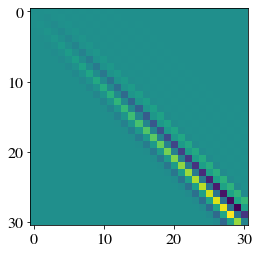

In [8]:
from fisher_information import displacement_operator

exact = displacement_operator(0.1, None)
approx = displacement_operator(0.1, 2)
residual = approx - exact
plt.imshow(residual)
plt.savefig("./figures/displacement_operator_truncation.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_8949/1435150640.py:12: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(rho)))


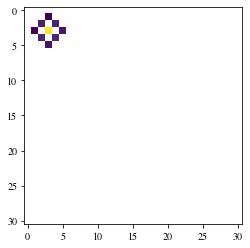

In [35]:
from fisher_information import Nmax

rho = np.zeros((Nmax + 1, Nmax + 1))
n = 3
sigma = 0.01

rho[n, n] = 1 - 0.5 * (1 + 2 * n) * sigma**2
rho[n - 1, n - 1] = 0.5 * n * sigma**2
rho[n + 1, n + 1] = 0.5 * (1 + n) * sigma**2
rho[n, n - 2] = rho[n - 2, n] = 0.25 * np.sqrt((n - 1) * n) * sigma**2
rho[n + 1, n - 1] = rho[n - 1, n + 1] = -0.5 * np.sqrt(n * (n + 1)) * sigma**2
rho[n + 2, n] = rho[n, n + 2] = 0.25 * np.sqrt((n + 1) * (n + 2)) * sigma**2

plt.imshow(np.log(np.abs(rho)))
plt.show()

### FI versus measurement loss plot

In [6]:
def data_for_plot_versus_eta(eta_meas_list, n_input, settings):
    r = np.arcsinh(np.sqrt(n_input))
    data = pd.DataFrame(
        np.empty((len(eta_meas_list), 4)),
        columns=["eta", "CFI_Fock", "QFI_Fock", "QFI_SMSV"],
    )
    data["eta"] = eta_meas_list
    for i, eta in enumerate(eta_meas_list):
        data["CFI_Fock"].iloc[i], data["QFI_Fock"].iloc[i] = FIs(
            loss_channel=lambda rho: loss_binomial(rho, eta), **settings
        )
        data["QFI_SMSV"].iloc[i] = QFIM_SMSV(settings["sigma"], r=r, eta=eta)

        # TODO: prevent QFI NaNs for Fock

    return data

In [ ]:
n_input = 3
settings = dict(
    delta_sigma=1e-10,
    encoding=lambda sigma: encode_Fock_state(n_input, sigma),
)

eta_meas_list = np.concatenate(
    ([0], np.geomspace(1e-9, 1e-1, 9), np.linspace(0.1, 0.9, 4)[1:])
)

Big plot

In [7]:
# sigma_list = np.geomspace(1e-5, 1e-1, 5)
sigma_list = np.geomspace(1e-4, 1e-1, 4)

data_dict = {}
for sigma in sigma_list:
    data_dict[sigma] = data_for_plot_versus_eta(
        eta_meas_list, n_input, {"sigma": sigma, **settings}
    )

# TODO: pickle and save dict to .h5

/home/james/Code/PhD/source/pleasantPheasant/numerical_environment.py:179: RuntimeWarning: invalid value encountered in true_divide
  cfi_summand = dPn_dalpha**2 / (0.5 * (Pn1 + Pn2))
/home/james/Code/PhD/source/pleasantPheasant/./from_Simon/python_translation/QFImixed_finite.py:44: RuntimeWarning: invalid value encountered in double_scalars
  4
/home/james/Code/PhD/source/pleasantPheasant/numerical_environment.py:179: RuntimeWarning: invalid value encountered in true_divide
  cfi_summand = dPn_dalpha**2 / (0.5 * (Pn1 + Pn2))
/home/james/Code/PhD/source/pleasantPheasant/./from_Simon/python_translation/QFImixed_finite.py:44: RuntimeWarning: invalid value encountered in double_scalars
  4


KeyboardInterrupt: 

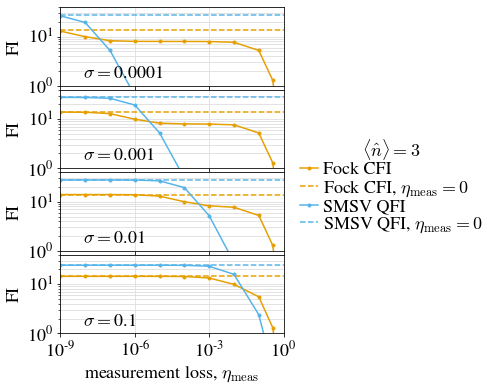

In [4]:
plt.rcParams.update({"font.size": 18})
fig, axs = plt.subplots(
    len(data_dict),
    1,
    sharex=True,
    sharey=True,
    figsize=(4, 6),
    gridspec_kw={
        # "wspace": 1,
        "hspace": 0.05,
    },
)

c0, c1 = COLOURS["Orange"], COLOURS["Sky blue"]

for i, (sigma, data) in enumerate(data_dict.items()):
    axs[i].loglog(data["eta"], data["CFI_Fock"], marker=".", label="Fock CFI", color=c0)
    axs[i].axhline(
        data["CFI_Fock"].iloc[0],
        linestyle="--",
        color=c0,
        label=r"Fock CFI, $\eta_\mathrm{meas}=0$",
    )
    axs[i].loglog(data["eta"], data["QFI_SMSV"], marker=".", label="SMSV QFI", color=c1)
    axs[i].axhline(
        data["QFI_SMSV"].iloc[0],
        linestyle="--",
        color=c1,
        label=r"SMSV QFI, $\eta_\mathrm{meas}=0$",
    )
    axs[i].grid("major", "both", color="gainsboro")
    axs[i].set(
        ylabel="FI",
    )
    axs[i].text(0.1, 0.1, rf"$\sigma=${sigma:.1g}", transform=axs[i].transAxes)

axs[2].legend(
    handlelength=1,
    labelspacing=0,
    frameon=False,
    handletextpad=0.3,
    fontsize=18,
    bbox_to_anchor=(1, 0),
    loc="lower left",
    title=rf"$\langle\hat n\rangle={n_input}$",
)
axs[-1].set(
    xlabel=r"measurement loss, $\eta_\mathrm{meas}$",
    xlim=(min(eta_meas_list[1:]), 1),
    ylim=(1, 40),
)

fig.savefig("./figures/channel_FI_versus_loss.pdf", bbox_inches="tight")
plt.show()

#### Old single plot

Generate data

In [14]:
sigma = 0.001
data = data_for_plot_versus_eta(eta_meas_list, n_input, {"sigma": sigma, **settings})

# save data
file = "./data/Fock_SMSV_versus_eta.txt"
data.to_csv(file, index=False)

/home/james/Code/PhD/source/pleasantPheasant/numerical_environment.py:179: RuntimeWarning: invalid value encountered in true_divide
  cfi_summand = dPn_dalpha**2 / (0.5 * (Pn1 + Pn2))
/home/james/Code/PhD/source/pleasantPheasant/./from_Simon/python_translation/QFImixed_finite.py:44: RuntimeWarning: invalid value encountered in double_scalars
  4


Plot

In [15]:
# load data
file = "./data/Fock_SMSV_versus_eta.txt"
data = pd.read_csv(file)

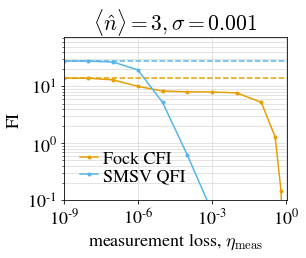

In [16]:
plt.rcParams.update({"font.size": 18})
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

c0, c1 = COLOURS["Orange"], COLOURS["Sky blue"]

ax.loglog(data["eta"], data["CFI_Fock"], marker=".", label="Fock CFI", color=c0)
ax.axhline(
    data["CFI_Fock"].iloc[0],
    linestyle="--",
    color=c0,
    # label=r"Fock CFI, $\eta_\mathrm{meas}=0$",
    # label=r"$\eta_\mathrm{meas}=0$ limit",
)
# ax.semilogy(data["eta"], data["QFI_Fock"], marker=".", label="Fock QFI (bugged)")
ax.loglog(data["eta"], data["QFI_SMSV"], marker=".", label="SMSV QFI", color=c1)
ax.axhline(
    data["QFI_SMSV"].iloc[0],
    linestyle="--",
    color=c1,
    # label=r"SMSV QFI, $\eta_\mathrm{meas}=0$",
    # label=r"$\eta_\mathrm{meas}=0$ limit",
)

ax.grid("both", "both", color="gainsboro")
ax.legend(
    handlelength=1,
    labelspacing=0,
    frameon=False,
    handletextpad=0.3,
    fontsize=18,
)

ax.set(
    title=rf"$\langle\hat n\rangle={n_input}, \sigma={sigma}$",
    xlabel=r"measurement loss, $\eta_\mathrm{meas}$",
    xlim=(min(eta_meas_list[1:]), 1.1),
    ylabel="FI",
    ylim=(1e-1, None),
)

fig.savefig("./figures/channel_FI_versus_loss---sigma_0.001.pdf", bbox_inches="tight")
plt.show()

### Optimisation to find cross-over point (bugged)

In [68]:
def cross_over_point(n_input, sigma, eta0=1e-6):
    r = np.arcsinh(np.sqrt(n_input))

    settings = dict(
        delta_sigma=1e-10,
    )
    rho1 = encode_Fock_state(n_input, sigma)
    rho2 = encode_Fock_state(n_input, sigma + settings["delta_sigma"])

    # minimiser
    def dist(eta, rho1, rho2):
        rho1 = loss_binomial(rho1, eta)
        rho2 = loss_binomial(rho2, eta)
        Fc_Fock = cfi_fock(rho1, rho2, settings["delta_sigma"])
        Fc_SMSV = QFIM_SMSV(sigma, r=r, eta=eta)
        return abs(Fc_Fock - Fc_SMSV)

    res = minimize(
        dist,
        [
            eta0,
        ],
        args=(
            rho1,
            rho2,
        ),
        bounds=[
            (0, 0.1),
        ],
        tol=1e-3,
    )
    return res

In [ ]:
n_input = 3
# sigma_list = np.geomspace(1e-5, 1e-3, 3)
sigma_list = [
    1e-5,
]

data = pd.DataFrame(
    np.empty((len(sigma_list), 3)), columns=["sigma", "eta_crossing", "CFI_crossing"]
)
data["sigma"] = sigma_list

# initial guess
eta0 = 1e-3
for i, sigma in enumerate(sigma_list):
    res = cross_over_point(n_input, sigma, eta0=eta0)
    print(res)
    data["CFI_crossing"].iloc[i] = res.fun
    data["eta_crossing"].iloc[i] = res.x
    # use previous guess in next look interation
    eta0 = res.x

# TODO: fix this optimiser, just finding the bounds presently